# DQN Agent - No reward

Train the DQNAgent for 1000 episodes and report its **loss** and **average cumulative reward** per episode.

In [1]:
import os
while os.path.basename(os.getcwd()) != "MountainCar-RL":
    os.chdir('..')

import gymnasium as gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from agents.DQN_agent import DQNAgent

from agents.MLP import QNetwork

## Agent training

In [2]:
seed = 105

torch.manual_seed(seed + 2)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed + 3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create env
max_episode_steps=200
env = gym.make('MountainCar-v0', max_episode_steps=max_episode_steps)

# Create agent
action_space = np.array([0, 1, 2])
action_space_size = action_space.size
state_size = 2

# Set up torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Create MLP
hidden_dims = [64] * 2
act = F.sigmoid
Q = QNetwork(state_size, action_space_size, hidden_dims, act=act)

# Setup hyperparameters
eps_max = 0.9
eps_min = 0.05
t_at_capacity = 100000  # number of iterations before reaching eps_min (e^-5 =~ 0)
eps = lambda t : eps_min + (eps_max - eps_min) * math.exp(-t * 5. / t_at_capacity)

gamma = 0.99
buffer_size = 10000
batch_size = 64
start_sampling = 1000

# Setup optimizer
lr = 0.001
weight_decay = 0.01
optimizer = optim.AdamW(Q.parameters(), lr=lr, weight_decay=weight_decay)

agent = DQNAgent(action_space, Q, optimizer,
                 gamma=gamma, eps=eps, buffer_size=buffer_size, batch_size=batch_size, start_sampling=start_sampling,
                 device=device, random_seed=seed)

Running on cpu


In [3]:
n_episodes = 1000

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
losses = np.zeros(n_episodes, dtype=float)
rewards = np.zeros(n_episodes, dtype=float)

rng_seed = np.random.default_rng(seed + 1)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_reward = 0
    episode_loss = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        agent.observe(state, action, next_state, reward)
        loss = agent.update()

        state = next_state
        done = terminated or truncated

        episode_reward += reward
        episode_steps += 1
        episode_loss += loss if loss is not None else 0
    
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, Loss: {episode_loss/episode_steps: .2e}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")
    
    durations[episode] = episode_steps
    losses[episode] = episode_loss/episode_steps
    rewards[episode] = episode_reward

Episode: 0, Reward: -200.0000, Loss:  0.00e+00, Steps: 200, epsilon:  0.8915
Episode: 1, Reward: -200.0000, Loss:  0.00e+00, Steps: 200, epsilon:  0.8832
Episode: 2, Reward: -200.0000, Loss:  0.00e+00, Steps: 200, epsilon:  0.8749
Episode: 3, Reward: -200.0000, Loss:  0.00e+00, Steps: 200, epsilon:  0.8667
Episode: 4, Reward: -200.0000, Loss:  2.65e-03, Steps: 200, epsilon:  0.8585
Episode: 5, Reward: -200.0000, Loss:  6.52e-01, Steps: 200, epsilon:  0.8505
Episode: 6, Reward: -200.0000, Loss:  4.87e-01, Steps: 200, epsilon:  0.8425
Episode: 7, Reward: -200.0000, Loss:  3.50e-01, Steps: 200, epsilon:  0.8346
Episode: 8, Reward: -200.0000, Loss:  2.41e-01, Steps: 200, epsilon:  0.8268
Episode: 9, Reward: -200.0000, Loss:  1.63e-01, Steps: 200, epsilon:  0.8191
Episode: 10, Reward: -200.0000, Loss:  1.07e-01, Steps: 200, epsilon:  0.8115
Episode: 11, Reward: -200.0000, Loss:  6.53e-02, Steps: 200, epsilon:  0.8039
Episode: 12, Reward: -200.0000, Loss:  4.09e-02, Steps: 200, epsilon:  0.7

**OPTIONAL: save results**

In [4]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'reward': rewards,
    'duration': durations,
    'loss': losses
}

df = pd.DataFrame(data)

# df.to_csv('results/B_train_DQN_noReward.csv', index=False)

## Plotting

**OPTIONAL: load results**

In [2]:
df = pd.read_csv('results/B_train_DQN_noReward.csv')

n_episodes = len(df.index)

seeds = df['seed'].to_numpy()
initial_xs = df['initial_x'].to_numpy()
rewards = df['reward'].to_numpy()
durations = df['duration'].to_numpy()
losses = df['loss'].to_numpy()

**PLOT: episodes duration**

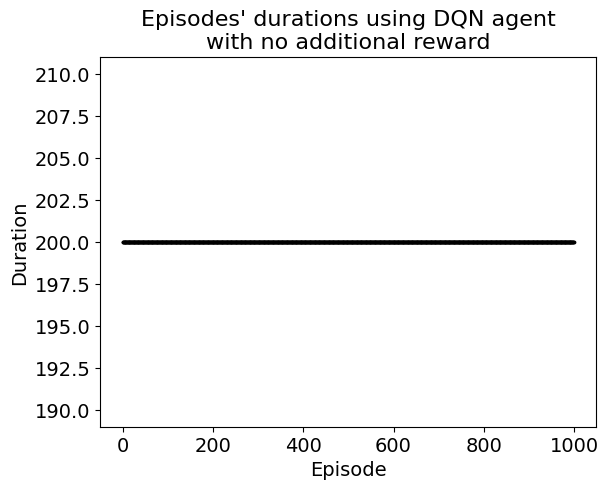

In [7]:
plt.scatter(range(n_episodes), durations, s=3, c='black', rasterized=True)
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' durations using DQN agent\nwith no additional reward", fontsize=16)
plt.savefig("plots/B_DQN_noReward_duration.pdf", format='pdf', transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training loss**

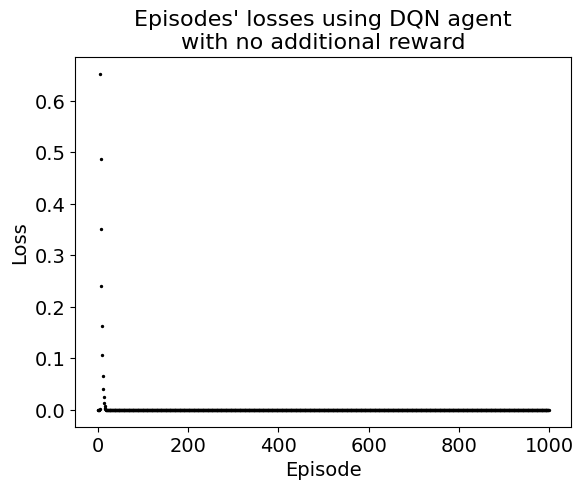

In [8]:
plt.scatter(range(n_episodes), losses, s=2, c='black', rasterized=True)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' losses using DQN agent\nwith no additional reward", fontsize=16)
plt.savefig("plots/B_DQN_noReward_loss.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()